### Making Business Decisions Based on Data.

##### Table of contents
0. [Introduction](#introduction)
1. [Download the data and prepare it for analysis.](#prepare)<br />
1.1 [Loading data in an optimized form.](#loading_data)<br />
1.2 [Data preprocessing](#data_preprocessing)<br />
2. [Prioritizing Hypotheses](#prioritizing)<br />
2.1 [ICE](#ice)<br />
2.2 [RICE](#rice)<br />
3. [A/B Test Analysis](#a_b_test)<br />
3.1 [Graph cumulative revenue by group.](#cumulative_revenue)<br />
3.2 [Graph cumulative average order size by group.](#cumulative_average_order_size)<br />
3.3 [Graph the relative difference in cumulative average order size for group B compared with group A.](#relative_average_order_size)<br />
3.4 [Calculate each group's conversion rate as the ratio of orders to the number of visits for each day.](#conversion_rate)<br />
3.5 [Plot a scatter chart of the number of orders per user.](#scatter_number_orders)<br />
3.6 [Calculate the 95th and 99th percentiles for the number of orders per user.](#percentiles_number_orders)<br />
3.7 [Plot a scatter chart of order prices.](#scatter_order_prices)<br />
3.8 [Calculate the 95th and 99th percentiles of order prices.](#percentiles_order_prices)<br />
3.9 [Find the statistical significance of the difference in conversion between the groups using the raw data.](#statistical_significance_conversion)<br />
3.10 [Find the statistical significance of the difference in average order size between the groups using the raw data.](#statistical_significance_average_order)<br />
3.11 [Find the statistical significance of the difference in conversion between the groups using the filtered data.](#statistical_significance_conversion)<br />
3.12 [Find the statistical significance of the difference in average order size between the groups using the filtered data.](#statistical_significance_average_order_filtered)<br />
3.13 [Make a decision based on the test results.](#make_decision)


#### 0. Introduction<a name="introduction"></a><br />
I am an analyst at a large online store. Together with the marketing department, we have compiled a list of hypotheses that can help increase revenue.<br />

I need to prioritize these hypotheses, run an A / B test, and analyze the results.

#### Description of the data <br />

Dataset "hypotheses_us.csv"
- Hypotheses — brief descriptions of the hypotheses
- Reach — user reach, on a scale of one to ten
- Impact — impact on users, on a scale of one to ten
- Confidence — confidence in the hypothesis, on a scale of one to ten
- Effort — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.

Dataset "orders_us.csv"
- transactionId — order identifier
- visitorId — identifier of the user who placed the order
- date — of the order
- revenue — from the order
- group — the A/B test group that the user belongs to

Dataset "visits_us.csv"
- date — date
- group — A/B test group
- visits — the number of visits on the date specified in the A/B test group specified

#### 1. Download the data and prepare it for analysis.<a name="prepare"></a>

In [8]:
import pandas   as pd
from scipy import stats as st
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
pd.options.display.float_format = "{:.2f}".format
pd.set_option('display.max_colwidth', 400)

##### Preliminary analysis of the data structure.

In [15]:
hypotheses = pd.read_csv("datasets/hypotheses_us.csv", delimiter=";")
visits      = pd.read_csv('datasets/visits_us.csv')
orders = pd.read_csv("datasets/orders_us.csv")

In [16]:
print('Hypotheses: \n')
print(hypotheses.info())

Hypotheses: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
None


In [17]:
print('Visits: \n')
print(visits.info(),'\n')
print(visits['group'].value_counts())


Visits: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None 

group
A    31
B    31
Name: count, dtype: int64


We need to convert the "Group" field to the category type, and the "Date" field to the DateTime type.

In [18]:
print('Orders: \n')
print(orders.info(),'\n')
print(orders['group'].value_counts())

Orders: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None 

group
B    640
A    557
Name: count, dtype: int64


We need to convert the "Group" field to the category type, and the "Date" field to the DateTime type.

#### 1.2. Data preprocessing<a name="data_preprocessing"></a>

In [19]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [20]:
print('Duplicates found - ',hypotheses['Hypothesis'].duplicated().sum(),' records')
hypotheses

Duplicates found -  0  records


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [21]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [22]:
print('Duplicates found - ',visits[['date','group']].duplicated().sum(),' records')
visits[:5]

Duplicates found -  0  records


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [23]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [24]:
print('Duplicates found - ',orders.duplicated().sum(),' records')
orders[:5]

Duplicates found -  0  records


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.40,B
1,2804400009,3642806036,2019-08-15,15.20,B
2,2961555356,4069496402,2019-08-15,10.20,A
3,3797467345,1196621759,2019-08-15,155.10,B
4,2282983706,2322279887,2019-08-15,40.50,B


In [25]:
group_nunique = orders.groupby('visitorId', as_index = False).agg({'group':'nunique'})
incorrect_data = group_nunique[group_nunique['group'] == 2]
print('There are {:} clients who participated in both groups.'.format(len(incorrect_data)))

There are 58 clients who participated in both groups.


##### Conclusion:<br>
No missing data were found.<br>
No duplicates were found.<br>
There is no need to convert the data type.<br>
For convenience, we need to rename the columns. We will make all letters small.

However, it turned out that there are 58 buyers who are present in both groups. This will ruin the test result. We need to remove the data about these customers from the **Orders** and **Visits** tables.

<div class="alert alert-success" role="alert">
Reviewer's comment v. 1:
    
It’s great that you have checked data for duplicates and a missing values.
</div>

In [26]:
hypotheses = hypotheses.rename(str.lower, axis='columns')

In [27]:
# Let's make a list of clients who participate in two groups at the same time
customer_exclude = orders.groupby('visitorId', as_index = False).agg({'group':'nunique'})
customer_exclude = list(customer_exclude.query('group == 2')['visitorId'])

In [28]:
# Let's remove customer data from Orders table, which include in"customer_exclude" list.
orders_filtred = orders.query('visitorId not in @customer_exclude')

In [29]:
#Let's remove customer data from Visits table, which include in  "customer_exclude" list.
orders_temp = orders.query('visitorId in @customer_exclude').reset_index(drop = True)
# add column "Correct" with "-1" visit
orders_temp.loc[:,'corr'] = -1
orders_correcting_info = orders_temp.groupby(['date','group']).agg({'corr':'sum'}).fillna(0).reset_index(drop=False)
orders_correcting_info['corr'] = orders_correcting_info['corr'].astype(int)

visits_filtred = visits.merge(orders_correcting_info,
                              left_on=['date', 'group'],
                              right_on=['date', 'group'])

visits_filtred['visits'] = visits_filtred['visits'] + visits_filtred['corr'] 
visits_filtred = visits_filtred.drop('corr', axis=1)

In [30]:
visits[:6]

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667


In [31]:
visits_filtred[:6]

,date,group,visits
0,2019-08-01,A,718
1,2019-08-02,A,618
2,2019-08-04,A,712
3,2019-08-05,A,753
4,2019-08-06,A,664
5,2019-08-07,A,642


### 2. Prioritizing Hypotheses<a name="prioritizing"></a>

#### 2.1 ICE<a name="ice"></a>

In [32]:
# Почитаем рейтинг ICE
hypotheses['ice'] = hypotheses.apply(lambda x: 
                                     x['impact'] * x['confidence'] / x['effort'],
                                     axis=1)

hypotheses = hypotheses.sort_values(by='ice', ascending = False).reset_index(drop=True)
hypotheses

,hypothesis,reach,impact,confidence,effort,ice
0,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20
1,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33
2,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20
3,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00
4,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00
5,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00
6,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33
7,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12
8,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00


In [33]:
# Расставим приоритеты
hypotheses['priority_ice'] = (
    hypotheses.apply(lambda x: hypotheses[hypotheses['hypothesis'] == x['hypothesis']]
                     .index.values[0],
                     axis=1))
hypotheses[['hypothesis','ice','priority_ice']]
hypotheses['priority_ice'] = 9 - hypotheses['priority_ice']


#### 2.2 RICE<a name="rice"></a>

In [34]:
# Почитаем рейтинг RICE
hypotheses['rice'] = hypotheses.apply(lambda x: 
                                      x['impact'] * x['confidence'] * x['reach'] / x['effort'],
                                      axis=1)
hypotheses = hypotheses.sort_values(by='rice', ascending = False).reset_index(drop=True)

In [35]:
# Расставим приоритеты
hypotheses['priority_rice'] = (
    hypotheses.apply(lambda x: hypotheses[hypotheses['hypothesis'] == x['hypothesis']].
                     index.values[0],
                     axis=1))
hypotheses[['hypothesis','rice','priority_rice']]
hypotheses['priority_rice'] = 9 - hypotheses['priority_rice']

In [36]:
# Рассчитает на сколько позиций сменился приоритет
hypotheses['shift'] = hypotheses.apply(lambda x: x['priority_rice'] - x['priority_ice'], axis=1)

In [37]:
def color_negative_red(val):
    color = 'red' 
    if val >= 0:
        color = 'green'
    return 'color: %s' % color

In [38]:
( 
    hypotheses[['hypothesis','priority_rice','priority_ice','shift']].
    style.
    applymap(color_negative_red, 
             subset=['shift'])
)  

C:\Users\User\AppData\Local\Temp\ipykernel_23728\2846138334.py:4: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  applymap(color_negative_red,


,hypothesis,priority_rice,priority_ice,shift
0,Add a subscription form to all the main pages. This will help you compile a mailing list,9,7,2
1,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,5,3
2,Add two new channels for attracting traffic. This will bring 30% more users,7,8,-1
3,Show banners with current offers and sales on the main page. This will boost conversion,6,6,0
4,Launch a promotion that gives users discounts on their birthdays,5,9,-4
5,Change the category structure. This will increase conversion since users will find the products they want more quickly,4,2,2
6,Launch your own delivery service. This will shorten delivery time,3,4,-1
7,Add a customer review page. This will increase the number of orders,2,3,-1
8,Change the background color on the main page. This will increase user engagement,1,1,0


##### Conclusion:<br />
As we can see, when assigning a prioritization rating to RICE and ICE, hypotheses have different priorities. The "shift" column shows how many positions the priority changed when we prioritized using the RICE method. As we can see, the priority has increased for those hypotheses for which the potential audience reach (REACH) was higher. The more people our innovation affects, the more result we will get.

<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:
    
You correctly calculated ICE scores and identified the highest priority hypotheses. It will be nice to show RICE and ICE scores on the same plot. This makes it easier to analyze.
</div>

### 3. A/B Test Analysis<a name="a_b_test"></a>

#### 3.1 Graph cumulative revenue by group.<a name="cumulative_revenue"></a>

In [39]:
orders_filtred[:5]

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.40,B
1,2804400009,3642806036,2019-08-15,15.20,B
3,3797467345,1196621759,2019-08-15,155.10,B
4,2282983706,2322279887,2019-08-15,40.50,B
5,182168103,935554773,2019-08-15,35.00,B


In [40]:
dateGroup = orders_filtred[['date','group']].sort_values(by = 'date').drop_duplicates()
dateGroup[:5]

,date,group
103,2019-08-01,B
147,2019-08-01,A
209,2019-08-02,A
210,2019-08-02,B
344,2019-08-03,A


In [41]:
dateGroup['revenue'] = ( 
    dateGroup.
    apply(lambda x: orders_filtred[np.logical_and(orders_filtred['date'] <= x['date'],
                                                  orders_filtred['group'] == x['group'])]['revenue'].sum(),
          axis = 1)
)                            
dateGroup[:6] 

,date,group,revenue
103,2019-08-01,B,967.20
147,2019-08-01,A,2266.60
209,2019-08-02,A,3734.90
210,2019-08-02,B,3535.30
344,2019-08-03,A,5550.10
442,2019-08-03,B,4606.90


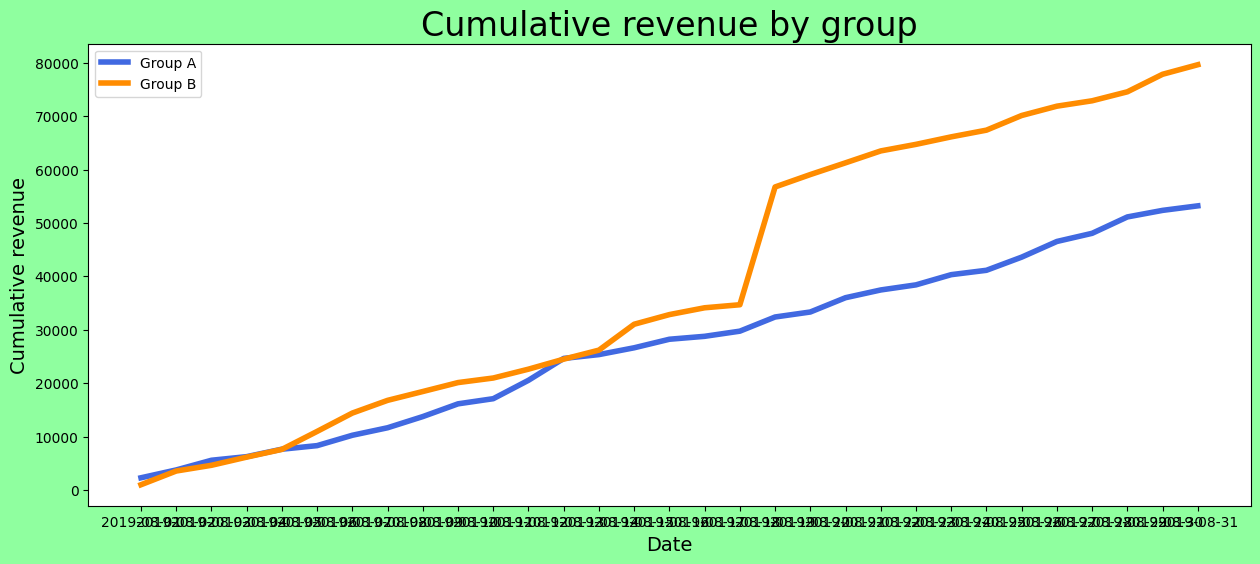

In [42]:
cumulativeRevenue_A = dateGroup[dateGroup['group'] == 'A']
cumulativeRevenue_B = dateGroup[dateGroup['group'] == 'B']

fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(cumulativeRevenue_A['date'],cumulativeRevenue_A['revenue'], 
         label = 'Group A', color = 'royalblue',linewidth=4.0) #darkgreen cornflowerblue
plt.plot(cumulativeRevenue_B['date'],cumulativeRevenue_B['revenue'], 
         label = 'Group B', color = 'darkorange',linewidth=4.0) #orange darkorange
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Cumulative revenue', fontsize=14)
ax.set_title('Cumulative revenue by group', fontsize=24)
fig.patch.set_facecolor('xkcd:mint green')
plt.legend()

plt.show()

##### Conclusion:<br />
Revenue is rising steadily throughout the whole test. That's a good sign.<br />
The cumulative revenue in group B is higher than in group A from the very beginning of testing. The charts have a similar trend, however, in Group B, there was an abnormal jump in revenue on 08/19/2019. In the next part, we will find out whether it is an anomaly or not.

<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:
    
During 17-18 of August we have increase of cumulative revenue for group B. Could you please explain it? (What is the possible reason of it)?
</div>

#### 3.2 Graph cumulative average order size by group.<a name="cumulative_average_order_size"></a>

In [43]:
#Let's calculate the number of orders per day. (cumulative)
dateGroup['n_orders'] = ( 
    dateGroup.
    apply(lambda x: orders_filtred[np.logical_and(orders_filtred['date'] <= x['date'],
                                                  orders_filtred['group'] == x['group'])]
          ['transactionId'].count(),
          axis = 1)
)                            
dateGroup[:6] 

,date,group,revenue,n_orders
103,2019-08-01,B,967.20,17
147,2019-08-01,A,2266.60,23
209,2019-08-02,A,3734.90,42
210,2019-08-02,B,3535.30,40
344,2019-08-03,A,5550.10,66
442,2019-08-03,B,4606.90,54


In [44]:
dateGroup['avg_order_size'] = (
    dateGroup.apply(lambda x: x['revenue'] / x['n_orders'] , axis = 1)
)
cumulativeAvgOrdersSize_A = dateGroup[dateGroup['group'] == 'A']
cumulativeAvgOrdersSize_B = dateGroup[dateGroup['group'] == 'B']

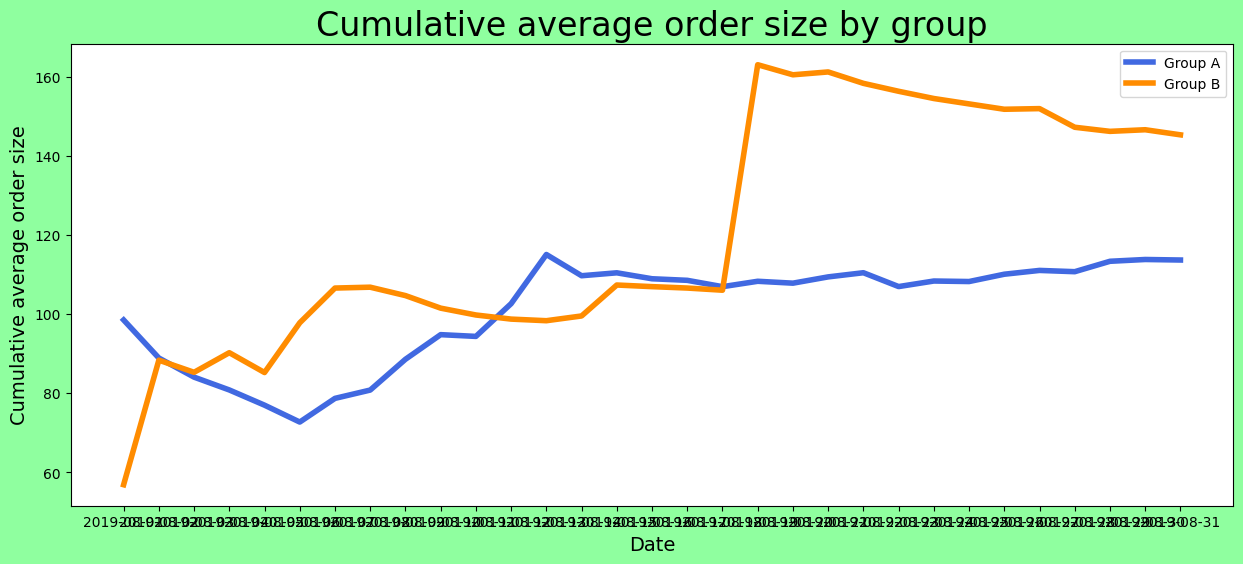

In [45]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(cumulativeAvgOrdersSize_A['date'], cumulativeAvgOrdersSize_A['avg_order_size'], 
         label = 'Group A', color = 'royalblue', linewidth=4.0) #darkgreen cornflowerblue
plt.plot(cumulativeAvgOrdersSize_B['date'], cumulativeAvgOrdersSize_B['avg_order_size'], 
         label = 'Group B', color = 'darkorange',linewidth=4.0) #orange darkorange
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Cumulative average order size', fontsize=14)
ax.set_title('Cumulative average order size by group', fontsize=24)
fig.patch.set_facecolor('xkcd:mint green')
plt.legend()

plt.show()

##### Conclusion:<br />

Average purchase size becomes steady by the end of the test, too: it stabilizes for group A and keeps on falling for group B. The surge in group B 18.08.2019 may have been due to the presence of large, expensive orders. We need more data on this group to find the true average purchase size and establish its level.<br /><br />
As we can see, the average purchase price in Group B is higher, but the trend is downtrend and it is not clear from the available data whether the average order price in Group B will fall below Group A.

<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:
    
It's great that you analyzed the graph in details.
</div>

#### 3.3 Graph the relative difference in cumulative average order size for group B compared with group A.<a name="relative_average_order_size"></a>

In [46]:
mergedCumulativeAvgOrdersSize = ( 
    cumulativeAvgOrdersSize_A[['date','avg_order_size']].
    merge(cumulativeAvgOrdersSize_B[['date','avg_order_size']], 
          on='date',
          suffixes=['A', 'B'])
)
mergedCumulativeAvgOrdersSize['relative_difference_avg_order_size'] = (
    mergedCumulativeAvgOrdersSize.
    apply(lambda x: (x['avg_order_sizeB'] / x['avg_order_sizeA']) - 1,
          axis = 1)
)

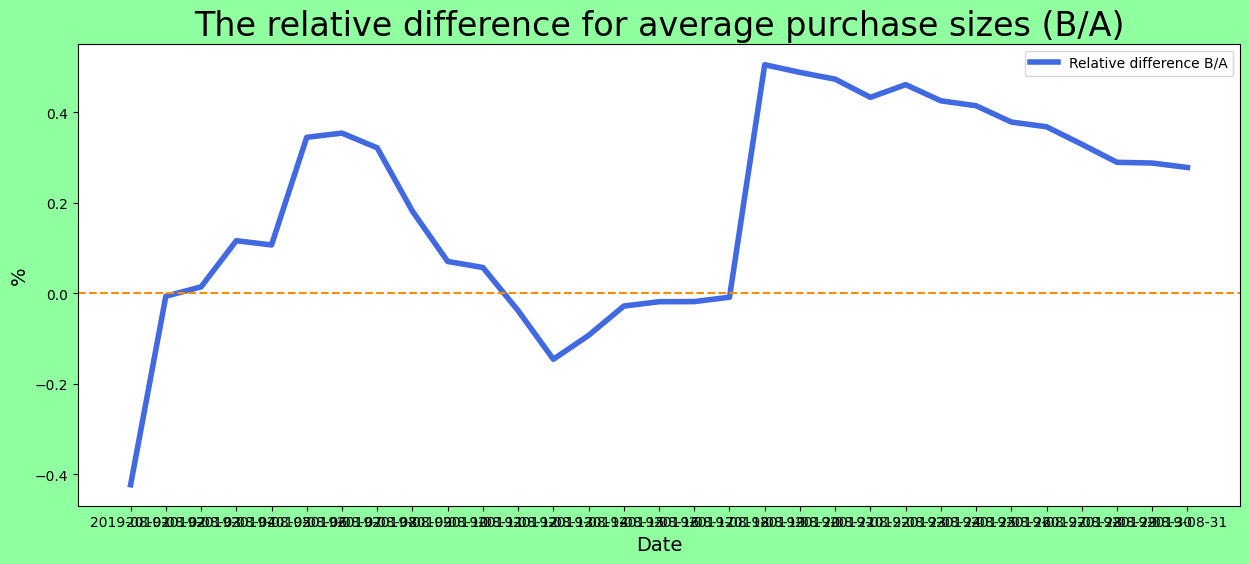

In [47]:
# plotting a relative difference graph for the average purchase sizes
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(mergedCumulativeAvgOrdersSize['date'], 
         mergedCumulativeAvgOrdersSize['relative_difference_avg_order_size'], 
         label = 'Relative difference B/A', color = 'royalblue', linewidth=4.0) #darkgreen cornflowerblue
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('%', fontsize=14)
ax.set_title('The relative difference for average purchase sizes (B/A)', fontsize=24)
fig.patch.set_facecolor('xkcd:mint green')
plt.axhline(y=0, color='darkorange', linestyle='--') 
plt.legend()

plt.show()

##### Conclusion: <br />
The chart has sharp reversals, which means that there are abnormally large orders in both groups. The trend of the chart is downtrend and we do not have enough data to make an unambiguous conclusion regarding the relative difference between the average order size.

#### 3.4 Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. <a name="conversion_rate"></a>

In [48]:
#Let's calculate the number of visiters per day. (cumulative)
dateGroup['n_visiters'] = ( 
    dateGroup.
    apply(lambda x: visits_filtred[np.logical_and(visits_filtred['date'] <= x['date'],
                                                  visits_filtred['group'] == x['group'])]
          ['visits'].sum(),
          axis = 1)
)   
dateGroup[:6]

,date,group,revenue,n_orders,avg_order_size,n_visiters
103,2019-08-01,B,967.20,17,56.89,709
147,2019-08-01,A,2266.60,23,98.55,718
209,2019-08-02,A,3734.90,42,88.93,1336
210,2019-08-02,B,3535.30,40,88.38,1289
344,2019-08-03,A,5550.10,66,84.09,1336
442,2019-08-03,B,4606.90,54,85.31,1796


In [49]:
dateGroup['conversion_rate'] = (
    dateGroup.
    apply(lambda x: (x['n_orders'] / x['n_visiters']),
          axis = 1)
)
conversion_rate_A = dateGroup[dateGroup['group'] == 'A']
conversion_rate_B = dateGroup[dateGroup['group'] == 'B']

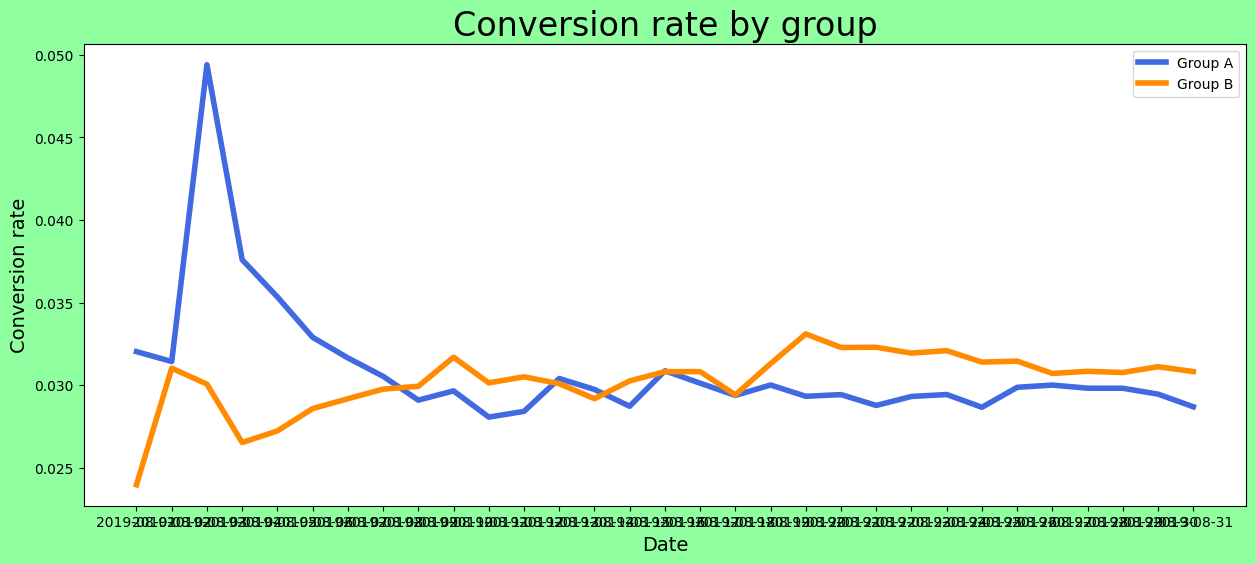

In [50]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(conversion_rate_A['date'], conversion_rate_A['conversion_rate'], 
         label = 'Group A', color = 'royalblue', linewidth=4.0) #darkgreen cornflowerblue
plt.plot(conversion_rate_B['date'], conversion_rate_B['conversion_rate'], 
         label = 'Group B', color = 'darkorange',linewidth=4.0) #orange darkorange
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Conversion rate', fontsize=14)
ax.set_title('Conversion rate by group', fontsize=24)
fig.patch.set_facecolor('xkcd:mint green')
plt.legend()

plt.show()

##### Conclusion: <br />
As we can see, the conversion in group B is higher. By the end of the period, the conversion charts have stabilized.

<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:
    
Yes, the conversion rate is stabilized by the end of the test.
</div>

#### 3.5 Plot a scatter chart of the number of orders per user.<a name="scatter_number_orders"></a>

In [51]:
number_orders_per_buyer = orders_filtred.groupby('visitorId').agg({'transactionId':'nunique'})
number_orders_per_buyer = ( 
    number_orders_per_buyer.rename(columns = {'transactionId':'count_orders'})
)
# calculate number of customers with one order
share_one_order = (
    len(number_orders_per_buyer[number_orders_per_buyer['count_orders'] == 1])
    /
    len(number_orders_per_buyer)
)
print('{:.2%} of customers make only one order'.format(share_one_order))

96.30% of customers make only one order


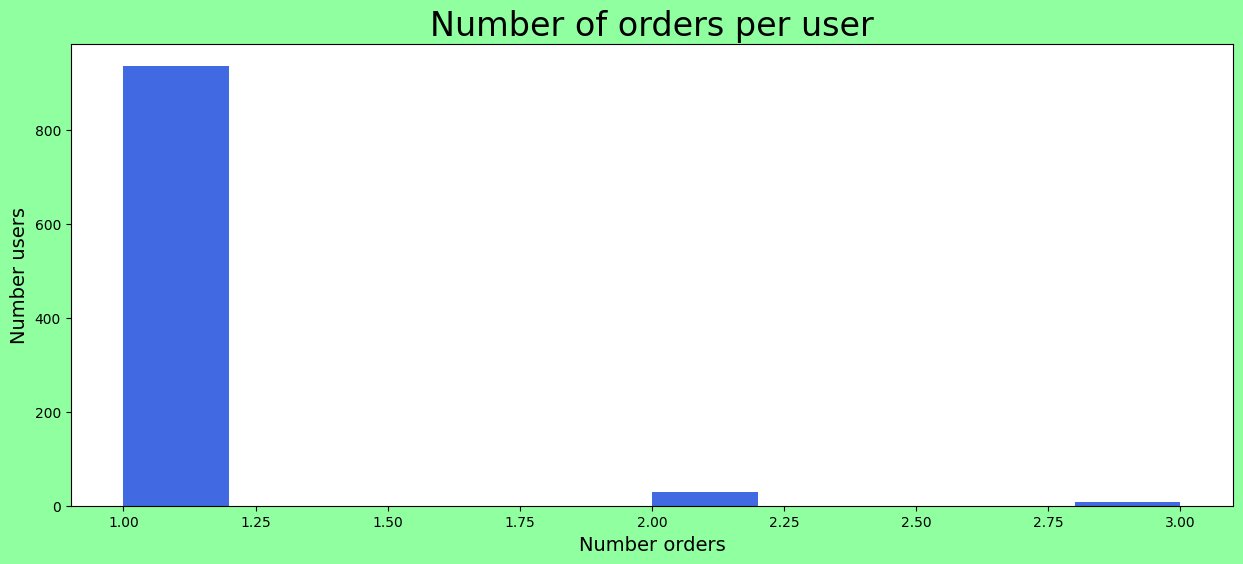

In [52]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.hist(number_orders_per_buyer['count_orders'], color = 'royalblue') 
ax.set_xlabel('Number orders', fontsize=14)
ax.set_ylabel('Number users', fontsize=14)
ax.set_title('Number of orders per user', fontsize=24)
fig.patch.set_facecolor('xkcd:mint green')

plt.show()

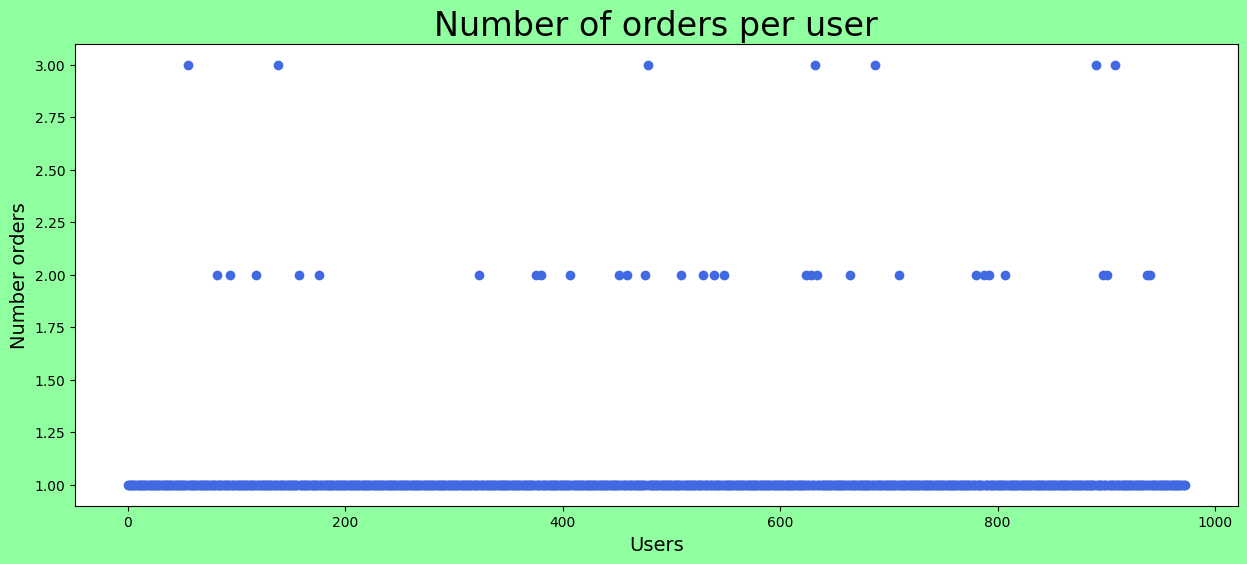

In [53]:
x_values = pd.Series(range(0,len(number_orders_per_buyer)))

fig, ax = plt.subplots(figsize=(15, 6))
plt.scatter(x_values, number_orders_per_buyer['count_orders'], color = 'royalblue') 
ax.set_xlabel('Users', fontsize=14)
ax.set_ylabel('Number orders', fontsize=14)
ax.set_title('Number of orders per user', fontsize=24)
fig.patch.set_facecolor('xkcd:mint green')

plt.show()

##### Conclusion: <br />
As you can see from both graphs, the majority of customers, **96.3%**, make only one order. It is impossible to say unambiguously whether it is a lot or a little. If our store sells foods, then this is a very low rate, as people buy foods much more often than once a month. If our store sells furniture, then you should not expect that customers are interested in our products very often. For each industry, the number of orders per customer per month will be different.

<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:
    
Yes, well done that you noted that the number of orders per customer per month will be different for different industry.
</div>

#### 3.6 Calculate the 95th and 99th percentiles for the number of orders per user.<a name="percentiles_number_orders"></a>

In [54]:
percentile_dict = [95, 99]
percentile = np.percentile(number_orders_per_buyer['count_orders'], percentile_dict)

print('Not more than {:}% of users placed more than {:.1f} orders'.
      format(100 - percentile_dict[0],percentile[0]))
print('Not more than {:}% of users placed more than {:.1f} orders'.
      format(100 - percentile_dict[1],percentile[1]))

Not more than 5% of users placed more than 1.0 orders
Not more than 1% of users placed more than 2.0 orders


Generally, the most extreme 1-5% of observed values are filtered out.<br />
Thus, it would be right to set **one** order per user as the lower limit for the number of orders and to filter anomalies on that basis. 

<div class="alert alert-success" role="alert">
Reviewer's comment v. 1:
    
Yes, the anomaly point in number of transactions per user is correctly defined.
</div>

#### 3.7 Plot a scatter chart of order prices.<a name="scatter_order_prices"></a>

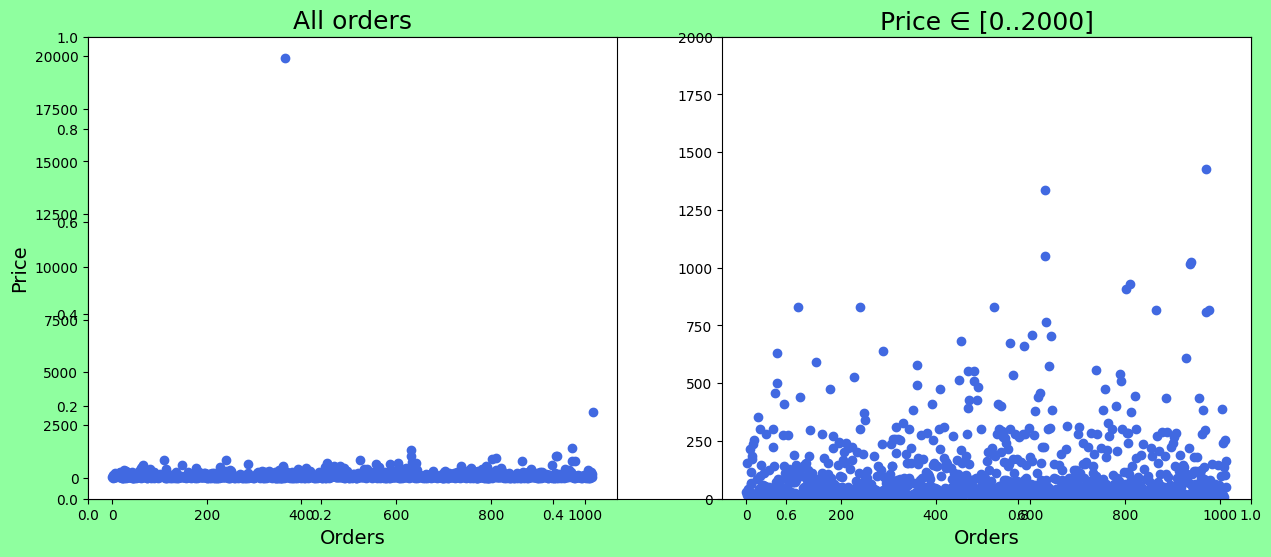

In [55]:
x_values = pd.Series(range(0,len(orders_filtred)))

fig, ax = plt.subplots(figsize=(15, 6))
fig.patch.set_facecolor('xkcd:mint green')
ax1 = plt.subplot(121)
res = plt.scatter(x_values, orders_filtred['revenue'], color = 'royalblue') 
ax1.set_ylabel('Price', fontsize=14)       
ax1.set_xlabel('Orders', fontsize=14)
ax1.set_title('All orders', fontsize=18)
    
ax2 = plt.subplot(122)
res = plt.scatter(x_values, orders_filtred['revenue'], color = 'royalblue') 

ax2.set_ylabel('')  
ax2.set_xlabel('Orders', fontsize=14)
ax2.set_title('Price ∈ [0..2000]', fontsize=18)
ax2.set_ylim([0, 2000])
plt.show()

##### Conclusion: <br />
Just as we expected, there are several big orders.<br />
The majority of customers place orders up to $ 500. In the next part, we will learn the cutoff threshold.


#### 3.8 Calculate the 95th and 99th percentiles of order prices. <a name="percentiles_order_prices"></a>

In [56]:
percentile = np.percentile(orders_filtred['revenue'], percentile_dict)
print('Not more than {:}% of users placed orders over {:.1f} dollars'.format(100 - percentile_dict[0],percentile[0]))
print('Not more than {:}% of users placed orders over {:.1f} dollars'.format(100 - percentile_dict[1],percentile[1]))

Not more than 5% of users placed orders over 414.3 dollars
Not more than 1% of users placed orders over 830.3 dollars


##### Conclusion: <br />
Generally, the most extreme 1-5% of observed values are filtered out.<br />
Thus, it would be right to set 500 dollars per order as the higher limit and to filter anomalies on that basis.

#### 3.9 Find the statistical significance of the difference in conversion between the groups using the raw data. <a name="statistical_significance_conversion"></a>

<div class="alert alert-danger" role="alert">
Reviewer's comment v. 1:
    
Please formulate the null and alternative hypotheses explicitly. Please note that this applies to all other statistical tests too.
</div>

<div class="alert alert-info">
Hypothesis Null: There's no difference in conversion between the groups.<br />
Hypothesis alternative: There's a difference in conversion between the groups.
<br /><br />
In this case: Hypothesis on the Equality of Two Population Means.

Each sample has more than 50 records, which means the samples are large enough to test hypotheses.

Set alpha = 0.05, since we are evaluating a hypothesis for a business problem.
<br /><br />
To test hypotheses, we use the Mann-Whitney method.
</div>

<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:
    
It's great that you formulated the null and alternative hypotheses explicitly.
</div>

In [57]:
#orders_filtred - table from which duplicates were removed in the first part of the project
# counting the number of buyers and the number of orders
ordersByUsers_A = ( 
    orders_filtred[orders_filtred['group'] == 'A'].
    groupby('visitorId').
    agg({'transactionId':'nunique'})
)

ordersByUsers_B = ( 
    orders_filtred[orders_filtred['group'] == 'B'].
    groupby('visitorId').
    agg({'transactionId':'nunique'})
)

ordersByUsers_A = ordersByUsers_A.rename(columns = {'transactionId':'orders'})
ordersByUsers_B = ordersByUsers_B.rename(columns = {'transactionId':'orders'})

In [58]:
#Creating a table for conversion analysis
sampleA = (
    pd.concat([ordersByUsers_A['orders'],
               pd.Series(0, 
                         index = np.arange(visits_filtred[visits_filtred['group'] == 'A']
                                           ['visits']
                                           .sum() 
                                           -
                                           len(ordersByUsers_A['orders'])),
                         name = 'orders')],
              axis=0)
)
sampleB = (
    pd.concat([ordersByUsers_B['orders'],
               pd.Series(0, 
                         index = np.arange(visits_filtred[visits_filtred['group'] == 'B']
                                           ['visits']
                                           .sum() 
                                           -
                                           len(ordersByUsers_B['orders'])),
                         name = 'orders')],
              axis=0)
)

In [59]:
# Let us find out whether we can reject the null hypothesis that there's not
# a statistically significant difference in conversion between the groups.
print("P-value : {0:.4f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
print("Conversion in group B is better by {0:.0f}%".
      format((sampleB.mean()/sampleA.mean()-1)*100))

P-value : 0.1819
Conversion in group B is better by 7%


##### Conclusion:<br />
Based on the raw data, there is a difference between groups A and B.<br />
P-value, 0.006, which is lower than 0.05. So we can reject the null hypothesis that there's not a statistically significant difference in conversion between the groups. The relative win of group B is 16%.

<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:

Ye, we have a statistically significant difference in conversion.
</div>

#### 3.10 Find the statistical significance of the difference in average order size between the groups using the raw data.<a name="statistical_significance_average_order"></a>

<div class="alert alert-info">
Hypothesis Null: The average order size is the same in both groups.<br />
Hypothesis alternative: The average order size is different in both groups.
   
In this case: Hypothesis on the Equality of Two Population Means.
Each sample has more than 50 records, which means the samples are large enough to test hypotheses.

Set alpha = 0.05, since we are evaluating a hypothesis for a business problem.
<br /><br />
To test hypotheses, we use the Mann-Whitney method.
</div>

<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:
    
Ok, a correct hypotheses formulation :)
</div>

In [60]:
revenue_A = orders_filtred[orders_filtred['group'] == 'A']['revenue']
revenue_B = orders_filtred[orders_filtred['group'] == 'B']['revenue']
print("P-value : {0:.3f}".format(st.mannwhitneyu(revenue_A, revenue_B)[1]))
print("Average order size in group B is better by {0:.3f}%".format((revenue_B.mean()/revenue_A.mean()-1)*100)) 

P-value : 0.862
Average order size in group B is better by 27.834%


##### Conclusion:<br />
The p-value (**0.43**) is considerably higher than 0.05, so there's no reason to reject the null hypothesis and conclude that average order size differs between the groups. The average order size for group B is much bigger than it is for group A (**28%**).

#### 3.11 Find the statistical significance of the difference in conversion between the groups using the filtered data. <a name="statistical_significance_conversion"></a>

As we determined earlier, orders greater than $ 500 or more than one order per customer would be considered abnormal.

In [61]:
ordersByUsers_A = ordersByUsers_A.reset_index()
ordersByUsers_B = ordersByUsers_B.reset_index()

In [62]:
# let's generate additional table with uid anomalies
usersWithManyOrders = pd.concat(
    [ordersByUsers_A[ordersByUsers_A['orders'] > 1]['visitorId'],
     ordersByUsers_B[ordersByUsers_B['orders'] > 1]['visitorId']],
     axis = 0)

usersWithExpensiveOrders = orders_filtred[orders_filtred['revenue'] > 500]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders,usersWithExpensiveOrders],axis = 0)
abnormalUsers = abnormalUsers.drop_duplicates().sort_values()
print('We have {:} anomalous users in total.'.format(len(abnormalUsers)))


We have 72 anomalous users in total.


<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:
    
Yes, these users can be considered as an anomally users.
</div>

Let's try to find out how anomalous users actions affected the test results. We'll calculate the statistical significance of the differences in conversion between the groups, using filtered data. First we'll prepare samples of the number of orders per user for each test group.

In [63]:
sampleA_filtered = ( 
    pd.concat(
        [ordersByUsers_A[np.logical_not(ordersByUsers_A['visitorId'].
                                        isin(abnormalUsers))]['orders'],
         pd.Series(0, 
                   index = np.arange(visits_filtred[visits_filtred['group']=='A']
                                     ['visits'].sum() 
                                     - 
                                     len(ordersByUsers_A['orders'])),
                   name='orders')],
        axis=0)
)
sampleB_filtered = ( 
    pd.concat(
        [ordersByUsers_B[np.logical_not(ordersByUsers_B['visitorId'].
                                        isin(abnormalUsers))]['orders'],
         pd.Series(0, 
                   index = np.arange(visits_filtred[visits_filtred['group']=='B']
                                     ['visits'].sum() 
                                     - 
                                     len(ordersByUsers_B['orders'])),
                   name='orders')],
        axis=0)
)

<div class="alert alert-info">
Hypothesis Null: There's no difference in conversion between the groups from which anomalies have been removed.<br />
Hypothesis alternative: There's a difference in conversion between the groups from which anomalies have been removed.
<br /><br />
In this case: Hypothesis on the Equality of Two Population Means.

Each sample has more than 50 records, which means the samples are large enough to test hypotheses.

Set alpha = 0.05, since we are evaluating a hypothesis for a business problem.
<br /><br />
To test hypotheses, we use the Mann-Whitney method.
</div>

In [64]:
print("P-value : {0:.4f}".format(st.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]))
print("Conversion in group B is better by {0:.0f}%".
      format((sampleB_filtered.mean()/sampleA_filtered.mean()-1)*100))

P-value : 0.1541
Conversion in group B is better by 10%


##### Conclusion:<br />
P-value, 0.005, which is lower than 0.05. So we can reject the null hypothesis.
We found that, according to the "purified" data, the conversion by groups also differed statistically significantly. The ratio of the mean values practically did not change.
It turns out that "anomalous" users had practically no effect on the value of this metric.

#### 3.12 Find the statistical significance of the difference in average order size between the groups using the filtered data.<a name="statistical_significance_average_order_filtered"></a>

<div class="alert alert-info">
Hypothesis Null: After removed the anomalies, the average order size in both groups is the same.<br />
Hypothesis alternative: After removed the anomalies, the average order size in both groups is different.
   
In this case: Hypothesis on the Equality of Two Population Means.
Each sample has more than 50 records, which means the samples are large enough to test hypotheses.

Set alpha = 0.05, since we are evaluating a hypothesis for a business problem.
<br /><br />
To test hypotheses, we use the Mann-Whitney method.
</div>

In [65]:
revenue_A_filtered = (
    orders_filtred[(np.logical_not(orders_filtred['visitorId'].
                                   isin(abnormalUsers)))                
                   & (orders_filtred['group'] == 'A')])['revenue']
revenue_B_filtered = (
    orders_filtred[(np.logical_not(orders_filtred['visitorId'].
                                   isin(abnormalUsers)))                
                   & (orders_filtred['group'] == 'B')])['revenue']

In [66]:
print("P-value : {0:.3f}"
      .format(st.mannwhitneyu(revenue_A_filtered, revenue_B_filtered)[1]))
print("Average order size in group B is better by {0:.1f}%"
      .format((revenue_B_filtered.mean()/revenue_A_filtered.mean()-1)*100))

P-value : 0.992
Average order size in group B is better by 1.6%


##### Conclusion:<br />
The p-value (**0.49**) is considerably higher than 0.05, so there's no reason to reject the null hypothesis and conclude that average order size differs between the groups. <br />
On the filtered data, the average order size for group B is the same as for group A. We can conclude that the anomalous values greatly influenced the result obtained earlier. Without abnormal values, the average order value does not change.

<div class="alert alert-success" role="alert">
Reviewer's comment v. 1:
    
Maybe this link will be interesting for you: https://www.analyticsvidhya.com/blog/2019/09/everything-know-about-p-value-from-scratch-data-science/
</div>

##### Conclusions on A / B testing:<br />

- there are statistically significant differences in conversion between groups A and B (both in raw data and in purified data)<br />
- there are no statistically significant differences in the average check between groups A and B (both for raw data and for purified data).

<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:
    
Yes, you are right, anomaly users don't have influence on the test results.
</div>

#### 3.13 Make a decision based on the test results. <a name="make_decision"></a>

As a result of the data obtained, I can advise you to stop testing. The test result can be considered positive. We determined that the data in the groups are statistically different, and the result in group B is 19% better. As for the average check, it has not changed between groups A and B. This tells us that our change will improve conversions and keep the average order value at the same level.

<div class="alert alert-danger" role="alert">
Reviewer's comment v. 1:
    
Please add a general conclusion. It's important part of the project which contains all main findings.
</div>

### 4. General conclusion

<div class="alert alert-info">

1. During the execution of this project, it was found that some users participated in two groups at the same time, which violates one of the basic principles of the A / B test - one user sees only one version site throughout the test.<br />Thus, we need to check the correctness of the processing of the method of displaying one or another version of the site to users.<br /><br />

2. The priority of hypothesis testing was calculated using the RICE method. The following hypotheses have received the highest priority:<br />
 - "Add a subscription form to all the main pages".<br />
 - "Add product recommendation blocks to the store's site"<br /><br />

3. We got the results of A / B testing. The test result can be considered positive. Based on the test results, it was found that the conversion rate will increase when changes are made, and the average price will remain the same.<br />
When analyzing the data, it was found that more than 96% of customers place only one order worth up to $ 413. However, there are customers who place 3 or more orders.
    
</div>

<div class="alert alert-success" role="alert">
Reviewer's comment v. 2:
    
An excellent conclusion which highlights all the main results of the project. Well done that you add recommendations about the tests. It's important information for marketing specialists.
</div>